In [ ]:
import gc
import pickle
import bz2
import os
import pandas as pd

In [ ]:
CARD_LBE = './hw1/card_lbe.pkl.bz2'
DOC_LBE = './hw1/doc_lbe.pkl.bz2'


with bz2.open(CARD_LBE, 'rb') as f:
    cards = pickle.load(f)

with bz2.open(DOC_LBE, 'rb') as f:
    doc = pickle.load(f)

In [ ]:
with bz2.open('./hw1/09_prepared.pkl.bz2', 'rb') as f:
    df1 = pickle.load(f).drop(['id_doc', 'id_card'], axis=1)

with bz2.open('./hw1/10_prepared.pkl.bz2', 'rb') as f:
    df2 = pickle.load(f).drop(['id_doc', 'id_card'], axis=1)

with bz2.open('./hw1/11_prepared.pkl.bz2', 'rb') as f:
    df3 = pickle.load(f).drop(['id_doc', 'id_card'], axis=1)

In [ ]:
df = pd.concat([df1, df2, df3])
del df1, df2, df3 # 11gbs of RAM
gc.collect()

4643

In [ ]:
pd.set_option('display.float_format', str)
df.head()

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
0,2020-09-01 17:01:25,0,52,271,1.0,108.0,False,1538855,1283228
1,2020-09-01 17:35:36,0,52,271,1.0,108.0,False,267307,8873113
2,2020-09-01 19:19:21,0,52,271,1.0,107.95,False,610220,12712899
3,2020-09-01 21:53:34,0,52,271,1.0,108.0,False,441497,21535283
4,2020-09-01 18:42:31,0,61,97,2.0,88.0,False,1065358,642341


In [ ]:
cards.head()

,id_card,id_card_int
0,8594499,1538855
1,1452388,267307
2,3493538,610220
3,2491281,441497
4,5732396,1065358


In [ ]:
doc.head()

,id_doc,id_doc_int
0,0E05D308-5CEC-EA11-B444-005056A7539A,1283228
1,610205A1-61EC-EA11-B444-005056A7539A,8873113
2,8AF19602-70EC-EA11-B444-005056A7539A,12712899
3,EB6C71A3-84EC-EA11-B444-005056A7539A,21535283
4,0706023F-6BEC-EA11-B444-005056A7539A,642341


A person (id_card) might be an outlier if

* They buy a lot of products (high quantity)
* They spend a lot of money per each transaction
* They shop often
* May be negative values in sum / quantity

The above gives a pretty good, solid check for a real human customer

First lets investigate the first point (buy a lot of products)

And now for per-receipt statistics

In [ ]:
per_receipt = df.groupby(['id_doc_int']).sum()

count          23417869.0
mean    8.054924883429827
std     72.19205452737451
min                   0.0
25%                 2.105
50%                 4.808
75%                 8.718
max               10002.0
Name: quantity, dtype: float64


<AxesSubplot:>

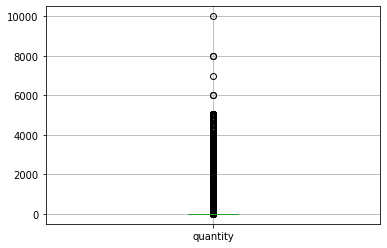

In [ ]:
print(per_receipt['quantity'].describe())
per_receipt[['quantity']].boxplot(whis=[0.05, 0.95])

Someone is buying a lot of products, e.g. 10k items per one go

It is safe to assume that person buying so many items per one go is suspicious (unreal scenario), so it's more likely an exchange between company branches, so lets remove them

Let's remove top 5% buyers, because 20 items/receipt seems reasonable enough

In [ ]:
shady = []
threshold = per_receipt['quantity'].quantile(0.95)
print('Threshold: ', threshold)
buys_a_lot = per_receipt[per_receipt['quantity'] >= threshold]['id_card_int']
shady += list(buys_a_lot)


Threshold:  19.248


Now lets check the money spend per each receipt

                    sum
count        23417869.0
mean  670.3900313999525
std   723.3327520145556
min                 0.0
25%              220.32
50%               443.8
75%               853.0
max             80405.0


<AxesSubplot:>

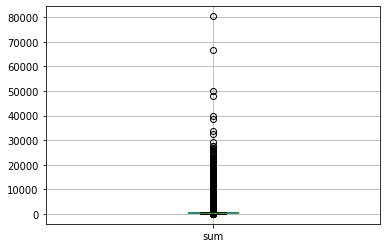

In [ ]:
print(per_receipt[['sum']].describe())
per_receipt[['sum']].boxplot(whis=[0.05, 0.95])

Here the threshold seems to be pretty low, because it is easy to spend more than 2k in one go

So, let's just use the threshold of 10k roubles, because it seems more reasonable

In [ ]:
threshold = per_receipt['sum'].quantile(0.95)
print('Threshold: ', threshold)
shady += list(per_receipt[per_receipt['sum'] >= 10000]['id_card_int'])
len(shady)

Threshold:  2025.71


1173110

Now let's check how often users buy things


count            1944075.0
mean    12.045764180908659
std      227.5524853009231
min                    1.0
25%                    2.0
50%                    5.0
75%                   14.0
max               316277.0
Name: id_doc_int, dtype: float64


<AxesSubplot:>

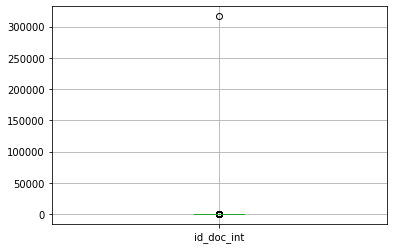

In [ ]:
buy_amount = df[['id_doc_int', 'id_card_int']].groupby(['id_card_int']).nunique().reset_index()
print(buy_amount['id_doc_int'].describe())
buy_amount[['id_doc_int']].boxplot()


Lets find that customer with 100k purchases per month

In [ ]:
hero = buy_amount.iloc[buy_amount.idxmax()['id_doc_int']]['id_card_int']
hero = df[df['id_card_int'] == hero]
hero.drop_duplicates(subset=['id_doc_int'])

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
1221,2020-09-01 13:41:07,0,20813,14782,1.0,168.0,False,883386,16003441
1853,2020-09-01 18:51:35,0,27495,14911,1.0,34.0,False,883386,12641780
1859,2020-09-01 18:04:23,0,27695,15385,2.0,152.0,False,883386,23313124
2009,2020-09-01 16:47:24,0,31712,-9999,1.0,167.0,False,883386,8364189
3068,2020-09-01 19:59:22,0,16306,13426,1.0,163.0,False,883386,15013745
...,...,...,...,...,...,...,...,...,...
46495735,2020-11-30 21:33:59,0,19493,20541,1.0,261.0,False,883386,8972695
46495920,2020-11-30 17:39:59,0,22560,14186,1.0,135.0,False,883386,15823137
46496028,2020-11-30 20:07:31,0,24554,12869,1.0,145.0,False,883386,15684187
46496194,2020-11-30 11:16:22,0,31936,20031,2.0,180.0,False,883386,21960612


More than 300 purchases in a time span of 3 months seems to be a little unrealistic value for the real customer

So, let's just use something like 40 as a threshold, it means that person goes shopping 3-4 times a week

In [ ]:
threshold = buy_amount[['id_doc_int']].quantile(0.95)
print('Threshold: ', threshold)
shady += list(buy_amount[buy_amount[['id_doc_int']] >= 50]['id_card_int'])
len(shady)


Threshold:  id_doc_int   48.0
Name: 0.95, dtype: float64


3117185

Now let's consider negative and zero costs and quantities, first lets find out how frequent they are

In [ ]:
df[df["quantity"] < 0]

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
4206093,2020-09-04 09:10:21,0,23074,19269,-1.268,470.43,False,1301664,11939194
4206103,2020-09-04 09:09:24,0,23074,19269,-1.268,470.43,False,1419650,22549976
4210123,2020-09-04 08:37:00,0,23074,19269,-1.084,402.16,False,1035577,6745380
4218020,2020-09-04 08:43:37,0,23074,19269,-0.001,0.37,False,126995,16694740
4218022,2020-09-04 08:43:37,0,23074,19269,-2.375,881.13,False,126995,16694740
...,...,...,...,...,...,...,...,...,...
5382631,2020-09-04 09:13:44,0,23074,19269,-0.692,256.73,False,1538576,12752264
5396781,2020-09-04 08:37:49,0,23074,19269,-1.236,458.56,False,906517,2630312
5438902,2020-09-04 09:28:21,0,23074,19269,-0.572,212.21,False,1102820,21125316
5450158,2020-09-04 09:21:17,0,23074,19269,-0.915,339.47,False,574393,18763274


In [ ]:
df[df["sum"] < 0]


,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
4206092,2020-09-04 09:10:21,0,23074,19269,1.268,-470.43,False,1301664,11939194
4206102,2020-09-04 09:09:24,0,23074,19269,1.268,-470.43,False,1419650,22549976
4210124,2020-09-04 08:37:00,0,23074,19269,1.084,-402.16,False,1035577,6745380
4218019,2020-09-04 08:43:37,0,23074,19269,0.001,-0.37,False,126995,16694740
4218021,2020-09-04 08:43:37,0,23074,19269,2.375,-881.13,False,126995,16694740
...,...,...,...,...,...,...,...,...,...
5396780,2020-09-04 08:37:49,0,23074,19269,1.236,-458.56,False,906517,2630312
5438901,2020-09-04 09:28:21,0,23074,19269,0.572,-212.21,False,1102820,21125316
5450157,2020-09-04 09:21:17,0,23074,19269,0.915,-339.47,False,574393,18763274
5450159,2020-09-04 09:21:17,0,23074,19269,0.915,-339.47,False,574393,18763274


Not really, possibly those are just mistakes or their refund system - as you can see, the difference between the two tables is only the sign of quantity and sums

Maybe those are users returning their goods backs or something like that. No actions should be taken

Final step will be to deduplicate the list of "suspicious" users

In [ ]:
shady_users = pd.DataFrame(shady).drop_duplicates()
with bz2.open('out.pkl.bz2', 'wb') as out:
    pickle.dump(shady, out)

In total, almost a million of users is considered as outliers

In [ ]:
len(shady_users)



924567